# Feature Visualization in CNNs

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**Explainable AI (`XAI`), or Interpretable AI, or Explainable Machine Learning (`XML`), is an approach to artificial intelligence that aims to create models that are transparent, interpretable, and can provide human-understandable explanations for their decisions or predictions.**

**The goal of `XAI` is to improve the trustworthiness and reliability of AI systems, as well as to facilitate collaboration between humans and machines. `XAI` techniques include methods for visualizing model internals, feature importance analysis, and rule extraction, among others.** 

**By providing clear and interpretable explanations for the behavior of AI models, `XAI` can help to increase the transparency and accountability of these systems, which is particularly important in applications such as healthcare, finance, and law enforcement, where decisions made by AI models can have significant impacts on people's lives.** 

**As a response to the concerns raised against model opacity, the field of interpretability (specifically in CV applications) has formed two major threads of response: `feature visualization` and `saliency mapping`. This notebook focuses on feature visualization techniques.**

![image](https://christophm.github.io/interpretable-ml-book/images/cnn-features.png)

**For a comprehensive explanation of the limitations and difficulties related to feature visualization techniques, [we recommend this article](https://distill.pub/2017/feature-visualization/), made by _Chris Olah, Alexander Mordvintsev, and Ludwig Schubert_ (Google Brain Team).**

**For a complete guide on ML Explainability, we recommend "_[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)_" (by _[Christoph Molnar](https://christophmolnar.com/)_).**

**In this notebook, we will be interpreting a CNN trained on the `CIFAR-10` dataset. The `CIFAR-10` dataset ([Canadian Institute For Advanced Research](https://en.wikipedia.org/wiki/Canadian_Institute_for_Advanced_Research)) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research, containing 60,000 32x32 color images in 10 different classes. The ten classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks (there are 6,000 images of each class).**

**Convolutional layers are the de-facto standard in image classification. However, the training of a `CNN` (Convolutional neural network) is outside the scope of this notebook. So, we are just gonna upload a pre-trained model. You can find loads of tutorials on how to train a CNN in the literature, like in [_Deep Learning with Python_](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf), and in this [notebook](xxx).**


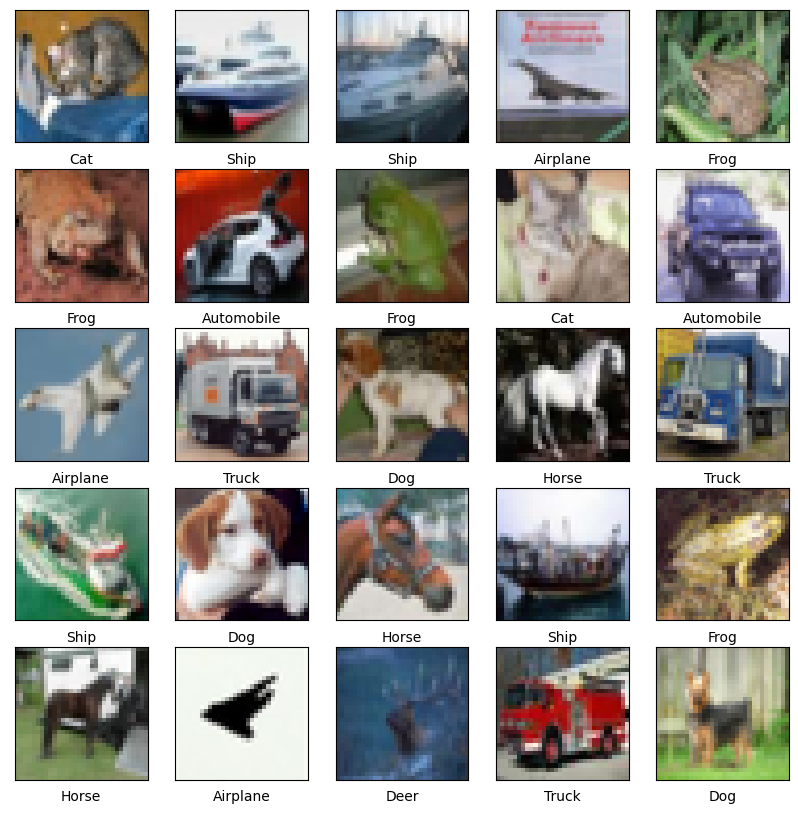

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [2]:
import tensorflow as tf
from keras import datasets
from keras.utils import np_utils
import matplotlib.pyplot as plt

(_, _), (x_test, y_test) = datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i][0]])

plt.show()

model = tf.keras.models.load_model('models/Cifar_CNN_Conv2D.keras')
model.summary()

x_test = x_test.astype('float32')
x_test = x_test / 255.
y_test = np_utils.to_categorical(y_test, 10)

test_loss_score, test_acc_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Loss: {round(test_loss_score, 2)}.')
print(f'Accuracy: {round(test_acc_score * 100, 2)} %.')


**Now let's write a function to return labels, predictions and images (feel free to write a better one).** 🙃


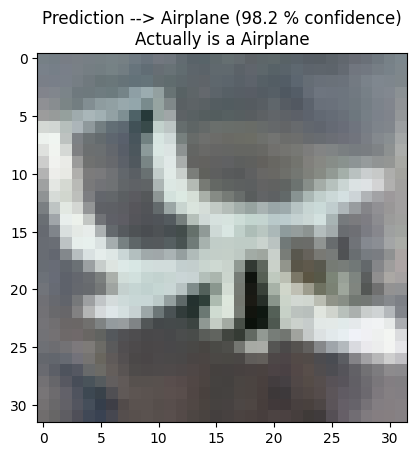

In [3]:
import numpy as np

def predict_image(x_test, y_test, sample):
    img_tensor = np.expand_dims(x_test[sample], axis=0)
    pred = [round(num, 3) for num in list(model.predict(img_tensor, verbose=0)[0])]
    plt.figure()
    plt.imshow(x_test[sample])
    plt.title(
        f'Prediction --> {class_names[np.array(pred).argmax()]} ({round(max(pred) * 100, 2)} % confidence)\nActually is a {class_names[y_test[sample].argmax()]}')
    return plt.show()

predict_image(x_test, y_test, np.random.randint(0, 9999))


### Visualizing Convolutional Layers

**The convolutional layers are the _foundation_ of `CNNs`, as they contain the learned kernels (weights), which extract features that distinguish different images from one another—this is what we want for classification. As you interact with the convolutional layer, you will notice links between the previous layers and the convolutional layers. Each link represents a unique kernel, which is used for the convolution operation to produce the current convolutional neuron’s output or activation map.**

![image](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Source: [cnn-explainer](https://poloclub.github.io/cnn-explainer/).**

**For `java` users, you can find a java visualization framework for CNNs in [here](https://poloclub.github.io/cnn-explainer/).**

**Identifying features in this way can help you understand what the network has learned, and how classifications are performed. Let's take the image of a _horse's head_, and analyze the activation maps of each layer in our network.**


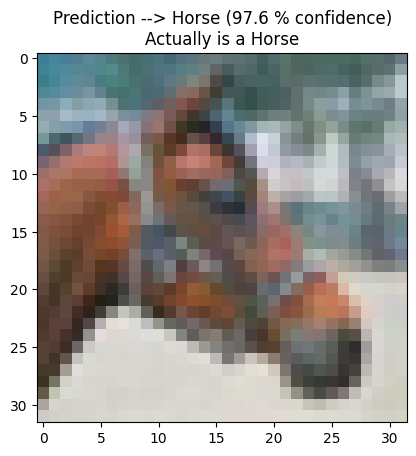

C:\Users\CWLINK\AppData\Local\Temp\ipykernel_15132\1016667534.py:30: RuntimeWarning:

invalid value encountered in divide

C:\Users\CWLINK\AppData\Local\Temp\ipykernel_15132\1016667534.py:30: RuntimeWarning:

divide by zero encountered in divide



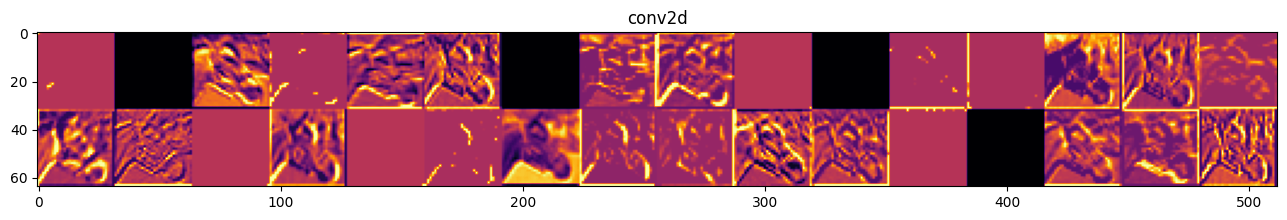

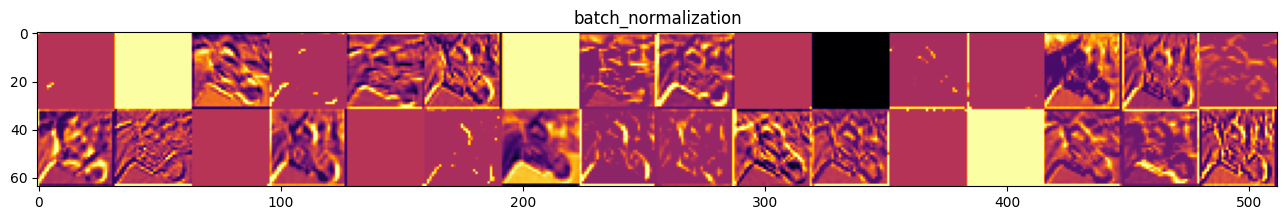

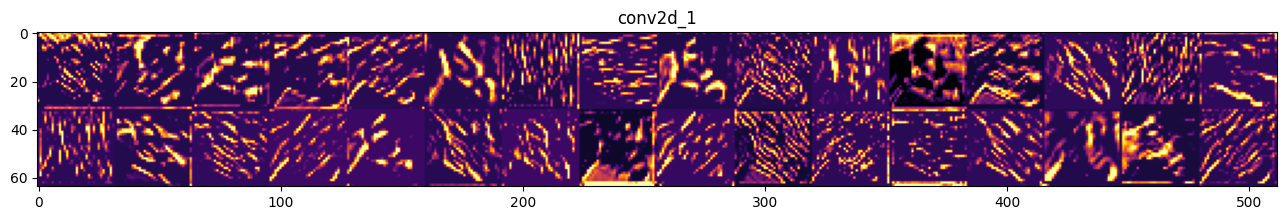

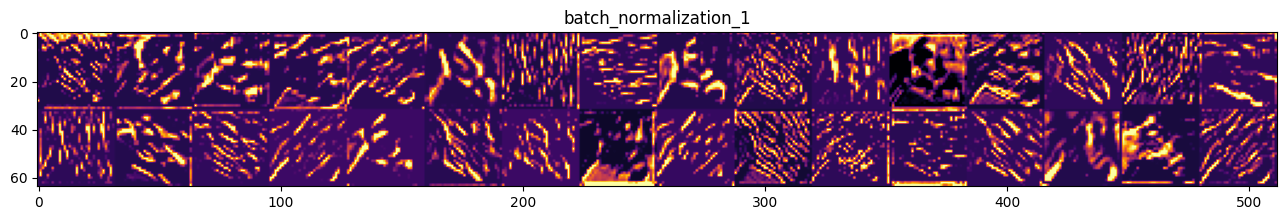

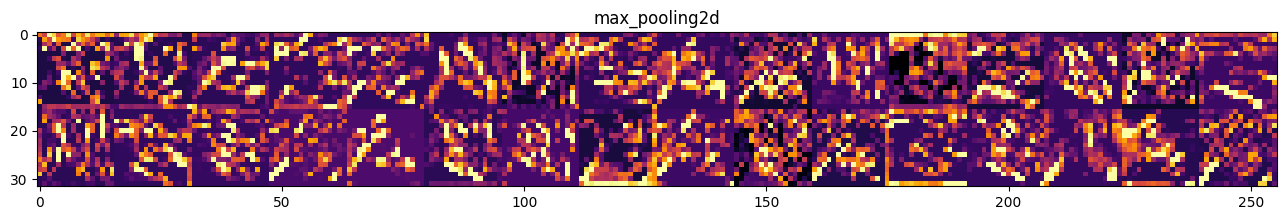

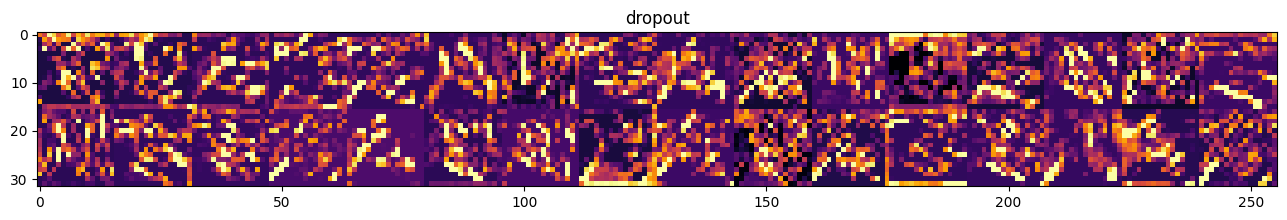

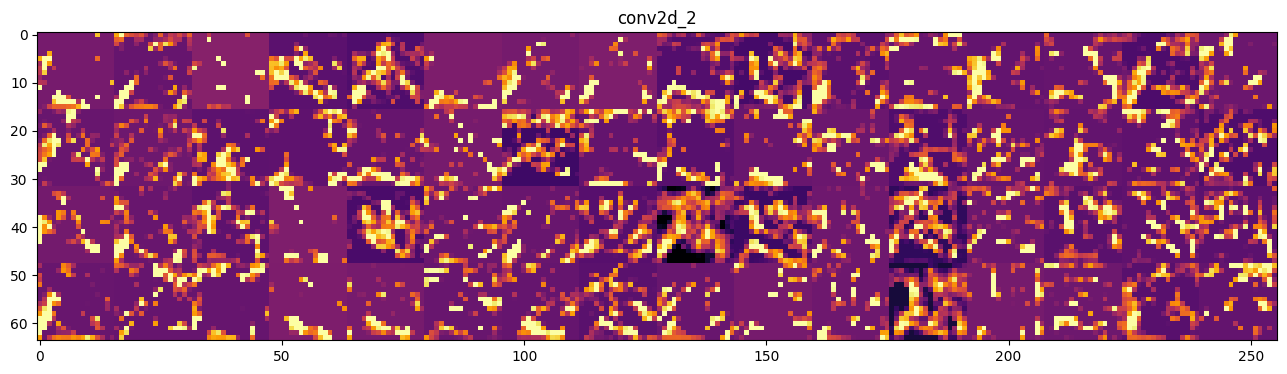

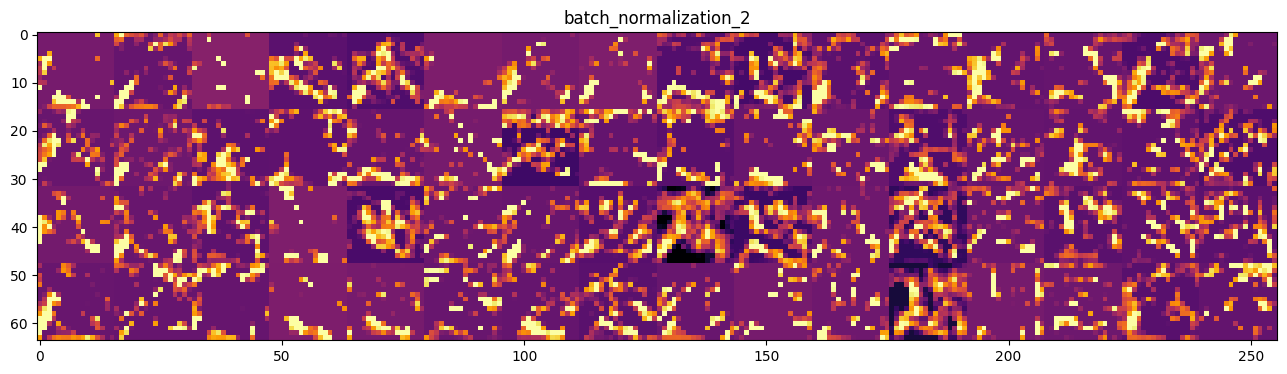

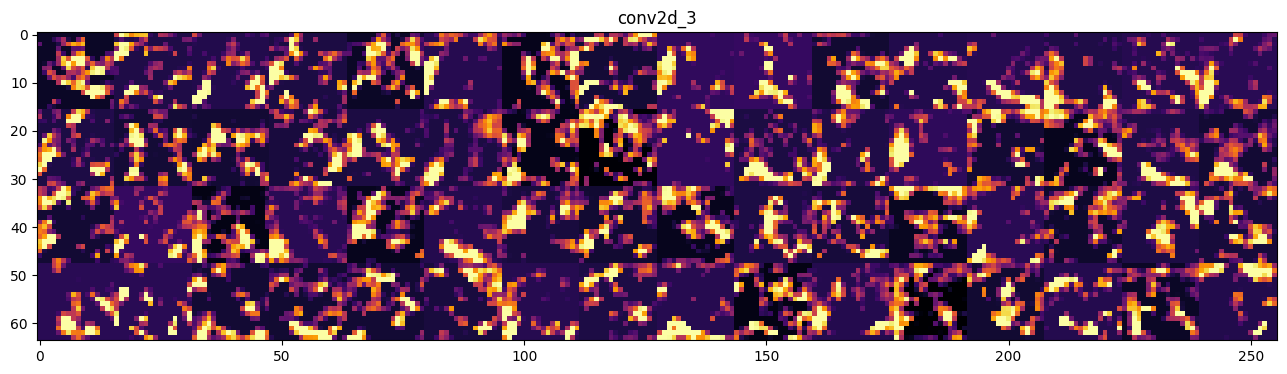

In [8]:
from keras import models

sample = 17
predict_image(x_test, y_test, sample)
img_tensor = np.expand_dims(x_test[sample], axis=0)

# Extracts the outputs of the top eight layers
layer_outputs = [layer.output for layer in model.layers[:18]]

# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor, verbose=0)
layer_names = []
for layer in model.layers[:9]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size,
                         row * size: (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='inferno')


## Visualize Activations of Individual Neurons

**We can also display the activation patterns that trigger individual neurons, to examine their activations and discover which features the network has learned.**

**For this, we build a loss function that maximizes the value of a given filter in a given convolution layer. By using `gradient ascent`, we can adjust the values of a blank input image to maximize this activation value.**

**For more information, read the "_[Circuits](https://distill.pub/2020/circuits/zoom-in/)_" series on [Distill](https://distill.pub/).**

![activation-features](https://distill.pub/2017/feature-visualization/images/objectives/channel.png)

**Bellow we made a feature visualization pipeline that can create an image of all filters learned by a certain convolutional block.**


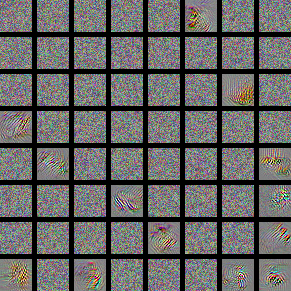

In [9]:
from IPython.display import Image

img_width = 32
img_height = 32
layer_name = 'conv2d_5'

layer = model.get_layer(name=layer_name)
feature_extractor = models.Model(inputs=model.inputs, outputs=layer.output)


def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # Avoid border artifacts by only involving non-border pixels in the loss
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


def initialize_image():
    img = tf.random.uniform((1, img_width, img_height, 3))
    return (img - 0.5) * 0.25


def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15
    img += 0.5
    img = np.clip(img, 0, 1)
    img *= 255
    img = np.clip(img, 0, 255).astype('uint8')
    return img


def visualize_filter(filter_index):
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)
    img = deprocess_image(img[0].numpy())
    return loss, img


all_imgs = []
for filter_index in range(128):
    #print('Processing filter %d' % (filter_index,), end = " ")
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

margin = 5
n = 8
cropped_width = img_width
cropped_height = img_height
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i: (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j: (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
tf.keras.utils.save_img(
    f'features_and_activations/Filters_in_{layer_name}(Cifar_CNN).png', stitched_filters)


display(Image(f'features_and_activations/Filters_in_{layer_name}(Cifar_CNN).png'))


**Here we can see filters in `block5_conv3` of the `VGG16` model (_trained on Imagenet_). Check the `features_and_activations` folder for more examples!**


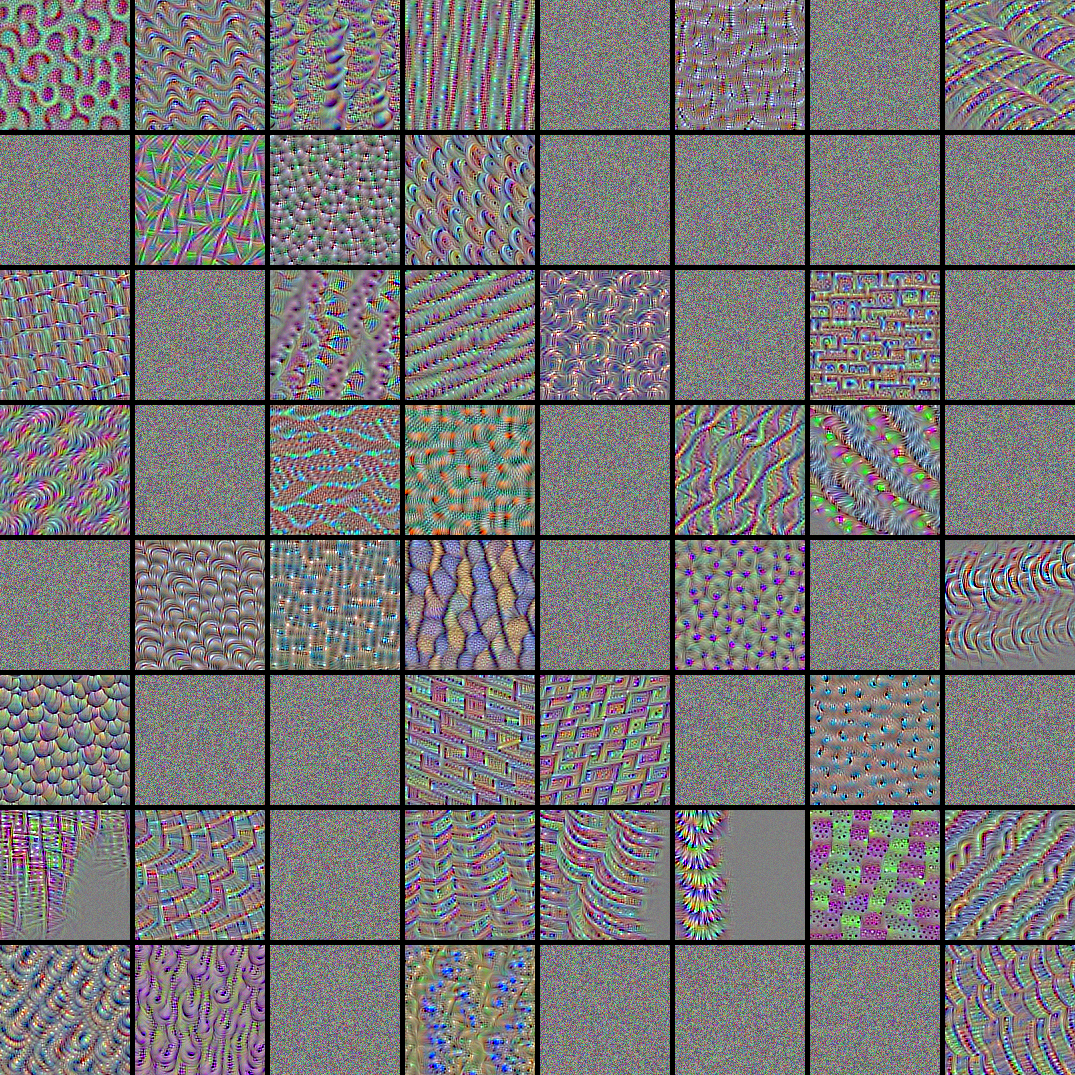

In [10]:
display(
    Image(
    filename=r'features_and_activations/VGG16_Filters_in_block4_conv1(VGG16).png'))

**You can use this generic pipeline to visualize the features of any Keras-based model. You can also load some of the many models that come with TensorFlow to explore their features (e.g., `VGG16`, `MobileNetV2`, etc.)** 🙃

----

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
